In [1]:
import warnings

warnings.filterwarnings("ignore")

import cmasher as cmr
import janitor
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from typing import Callable, List, Tuple, Optional

import numpy as np
import pandas as pd
import seaborn as sns

sns.set_theme(context="notebook", font_scale=1.1, style="whitegrid", palette="gray")

from utilities import save_mpl_fig

In [2]:
df_dl = pd.read_csv("../input/pkg_pypi_downloads.csv").assign(
    date=lambda df: pd.to_datetime(df["date"])
)
df_dl

,pkg,date,download_count,tt_downloads,treated,boughtstars,treated2
0,a-pandas-ex-df2htmlstring,2023-04-25,0.0,0.0,0,0,0
1,a-pandas-ex-df2htmlstring,2023-04-26,0.0,0.0,0,0,0
2,a-pandas-ex-df2htmlstring,2023-04-27,0.0,0.0,0,0,0
3,a-pandas-ex-df2htmlstring,2023-04-28,7.0,7.0,0,0,0
4,a-pandas-ex-df2htmlstring,2023-04-29,7.0,14.0,0,0,0
...,...,...,...,...,...,...,...
118175,zoomaker,2023-10-27,0.0,279.0,0,0,0
118176,zoomaker,2023-10-28,0.0,279.0,0,0,0
118177,zoomaker,2023-10-29,0.0,279.0,0,0,0
118178,zoomaker,2023-10-30,0.0,279.0,0,0,0


## Averages

In [11]:
# function
def plot_treated_vs_control(
    df: pd.DataFrame,
    date_col: str,
    value_col: str,
    treatment_col: str,
    estimator: str = "mean",
    ci: Optional[str] = None,
    annotate_dates: Optional[List[Tuple[str, str]]] = None,
    figsize_scale: float = 0.8,
    aspect_ratio: Tuple[int, int] = (12, 8),
    hue_order: List[int] = [2, 1, 0],
    style_order: List[int] = [2, 1, 0],
    palette_range: Tuple[float, float] = (0.5, 1),
    y_label: str = "Number of PyPI downloads",
    y_tick_formatter: Optional[Callable] = None,
    y_bins: int = 6,
    shade_start_date: Optional[str] = None,
    shade_end_date: Optional[str] = None,
    shade_color: str = ".6",
    shade_alpha: float = 0.5,
    shade_label: str = "Treatment period\n(12 May\u201319 May)",
    legend_order: List[int] = [2, 1, 0, 3],
    custom_labels: Optional[List[str]] = [
        "Control",
        "Treated (low dosage)",
        "Treated (high dosage)",
        "Treatment period\n(May 12\u201320)",
    ],
) -> None:
    """
    Plot treated vs control with a specified estimator function.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data to plot.
    date_col : str
        Name of the column containing the date values.
    value_col : str
        Name of the column containing the values to plot.
    treatment_col : str
        Name of the column containing the treatment indicators.
    estimator : Callable, optional
        Estimator function to use for plotting, by default sns.lineplot.
    ci : str, optional
        Confidence interval to display, by default None.
    annotate_dates : List[Tuple[str, str]], optional
        List of tuples with start and end dates for annotations, by default None.
    figsize_scale : float, optional
        Scale for the figure size, by default 0.8.
    aspect_ratio : Tuple[int, int], optional
        Aspect ratio for the figure, by default (12, 8).
    hue_order : List[int], optional
        Order of the hues, by default [2, 1, 0].
    style_order : List[int], optional
        Order of the styles, by default [2, 1, 0].
    palette_range : Tuple[float, float], optional
        Range for the palette, by default (0.5, 1).
    y_label : str, optional
        Label for the y-axis, by default "Number of PyPI downloads".
    y_tick_formatter : Callable, optional
        Formatter for the y-axis ticks, by default None.
    y_bins : int, optional
        Number of bins for the y-axis, by default 6.
    shade_start_date : str, optional
        Start date for shading, by default None.
    shade_end_date : str, optional
        End date for shading, by default None.
    shade_color : str, optional
        Color for shading, by default ".6".
    shade_alpha : float, optional
        Alpha value for shading, by default 0.5.
    shade_label : str, optional
        Label for shading, by default "Treatment period\n(12 May\u201319 May)".
    legend_order : List[int], optional
        Order for the legend items, by default [2, 1, 0, 3].
    custom_labels : List[str], optional
        Custom labels for the legend, by default None.

    Returns
    -------
    None
    """
    figsize = tuple(k * figsize_scale for k in aspect_ratio)
    _, ax = plt.subplots(figsize=figsize)

    sns.lineplot(
        data=df,
        x=date_col,
        y=value_col,
        markersize=12,
        hue=treatment_col,
        style=treatment_col,
        hue_order=hue_order,
        style_order=style_order,
        ci=ci,
        estimator=estimator,
        palette=cmr.get_sub_cmap("Greys", *palette_range),
        #         palette=["navy", "navy", "0"],
        ax=ax,
    )

    myFmt = mdates.DateFormatter("%-d %b")
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))

    if shade_start_date and shade_end_date:
        ax.axvspan(
            pd.to_datetime(shade_start_date),
            pd.to_datetime(shade_end_date),
            color=shade_color,
            alpha=shade_alpha,
            label=shade_label,
        )

    plt.locator_params(axis="y", nbins=y_bins)
    if y_tick_formatter:
        ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(y_tick_formatter))
    else:
        ax.get_yaxis().set_major_formatter(
            ticker.FuncFormatter(lambda x, p: format(int(x), ","))
        )

    ax.set_ylabel(y_label, fontsize=15)
    ax.set_xlabel("")

    handles, labels = ax.get_legend_handles_labels()
    shade_patch = Patch(color="grey", alpha=0.5, label="Shaded Area")
    handles.append(shade_patch)

    if not custom_labels:
        custom_labels = [
            "Control",
            "Treated (low dosage)",
            "Treated (high dosage)",
            shade_label,
        ]

    ax.legend(
        handles=[handles[idx] for idx in legend_order],
        labels=[custom_labels[idx] for idx in legend_order],
        title="",
        loc="upper left",
        fontsize=16,
        markerscale=1.5,
        markerfirst=True,
        frameon=False,
        handlelength=4,
    )

    plt.tight_layout()

In [12]:
common_opts = dict(
    df=df_dl,
    date_col="date",
    value_col="tt_downloads",
    treatment_col="treated2",
    shade_start_date="2023-05-12",
    shade_end_date="2023-05-20",
)

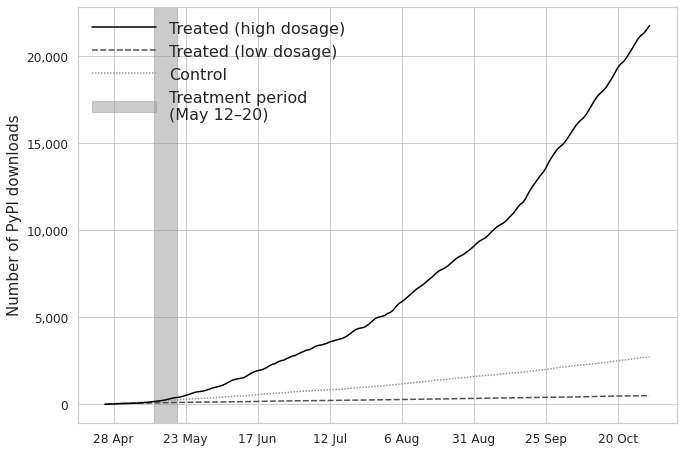

In [13]:
plot_treated_vs_control(**common_opts)
save_mpl_fig("../output/timeseries-downloads-treated-012")

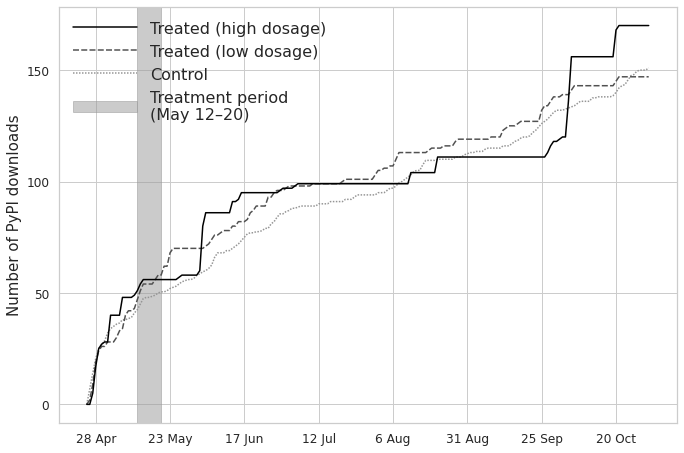

In [14]:
plot_treated_vs_control(**common_opts, estimator=np.median)
save_mpl_fig("../output/timeseries-downloads-treated-012-medians")

## Individual series

In [15]:
shade_start_date = "2023-05-12"
shade_end_date = "2023-05-20"
shade_color: str = ".6"
shade_alpha: float = 0.5

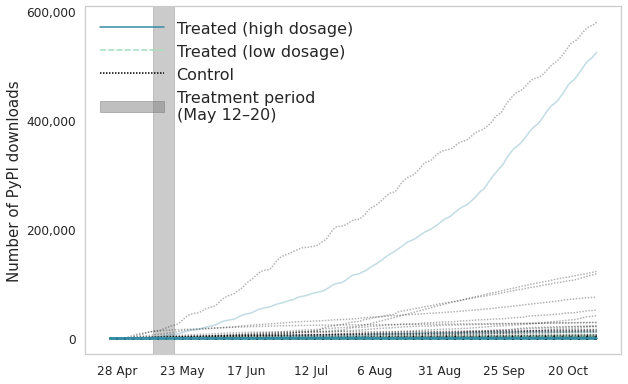

In [18]:
_scale = 0.8
_aspect_ratio = (12, 8)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

palette = sns.color_palette("mako_r", 3)

sns.lineplot(
    data=df_dl,
    x="date",
    y="tt_downloads",
    units="pkg",
    estimator=None,
    lw=1.5,
    alpha=0.3,
    hue="treated2",
    style="treated2",
    style_order=[2, 1, 0],
    #     palette=["",
    palette=[
        "0",
        "#a1dfb9",
        "#348ba6",
    ],
    ax=ax,
)

# Shade treatment period
ax.axvspan(
    pd.to_datetime(shade_start_date),
    pd.to_datetime(shade_end_date),
    color=shade_color,
    alpha=shade_alpha,
    #     label=shade_label
)

# Legend
handles, labels = ax.get_legend_handles_labels()
shade_patch = Patch(color="grey", alpha=0.5, label="Shaded Area")
handles.append(shade_patch)

custom_labels = [
    "Control",
    "Treated (low dosage)",
    "Treated (high dosage)",
    "Treatment period\n(May 12\u201320)",
]

legend_order = [2, 1, 0, 3]
ax.legend(
    handles=[handles[idx] for idx in legend_order],
    labels=[custom_labels[idx] for idx in legend_order],
    title="",
    loc="upper left",
    fontsize=16,
    markerscale=1.5,
    markerfirst=True,
    frameon=False,
    handlelength=4,
)


# Axis
myFmt = mdates.DateFormatter("%-d %b")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

plt.locator_params(axis="y", nbins=6)
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)

ax.set_ylabel("Number of PyPI downloads", fontsize=15)
ax.set_xlabel("")


ax.grid(False)  # Disable gridlines
save_mpl_fig("../output/timeseries-downloads-treated-012-individual")

In [19]:
df_dl.query("tt_downloads > 100_000")["pkg"].unique()

array(['dghs-imgutils', 'firebase-functions', 'pyaesm',
       'salt-analytics-framework'], dtype=object)

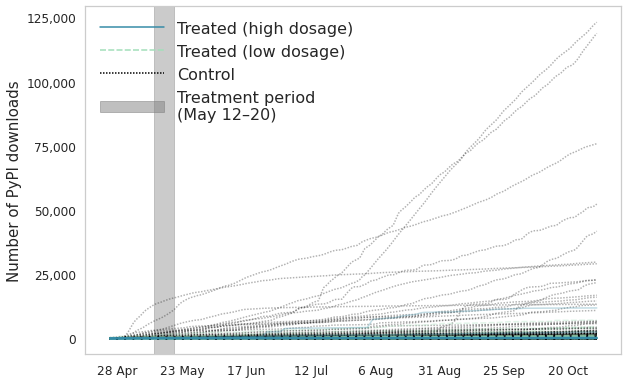

In [21]:
_scale = 0.8
_aspect_ratio = (12, 8)
figsize = tuple(k * _scale for k in _aspect_ratio)
_, ax = plt.subplots(figsize=figsize)

palette = sns.color_palette("mako_r", 3)

_df = df_dl.query("pkg!='firebase-functions'").query("pkg!='salt-analytics-framework'")
sns.lineplot(
    data=_df,
    x="date",
    y="tt_downloads",
    units="pkg",
    estimator=None,
    lw=1.5,
    alpha=0.3,
    hue="treated2",
    style="treated2",
    style_order=[2, 1, 0],
    #     palette=["",
    palette=[
        "0",
        "#a1dfb9",
        "#348ba6",
    ],
    ax=ax,
)

# Shade treatment period
ax.axvspan(
    pd.to_datetime(shade_start_date),
    pd.to_datetime(shade_end_date),
    color=shade_color,
    alpha=shade_alpha,
    #     label=shade_label
)

# Legend

handles, labels = ax.get_legend_handles_labels()
shade_patch = Patch(color="grey", alpha=0.5, label="Shaded Area")
handles.append(shade_patch)

custom_labels = [
    "Control",
    "Treated (low dosage)",
    "Treated (high dosage)",
    "Treatment period\n(May 12\u201320)",
]

legend_order = [2, 1, 0, 3]
ax.legend(
    handles=[handles[idx] for idx in legend_order],
    labels=[custom_labels[idx] for idx in legend_order],
    title="",
    loc="upper left",
    fontsize=16,
    markerscale=1.5,
    markerfirst=True,
    frameon=False,
    handlelength=4,
)


# Axis
myFmt = mdates.DateFormatter("%-d %b")
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

plt.locator_params(axis="y", nbins=6)
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ","))
)

ax.set_ylabel("Number of PyPI downloads", fontsize=15)
ax.set_xlabel("")


ax.grid(False)  # Disable gridlines
save_mpl_fig("../output/timeseries-downloads-treated-012-without-top2-extreme-outliers")